In [10]:
# In[0]

import torch 
import torch.nn as nn
import os
from PIL import Image
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary
import time

# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# cristian path 
base_dir = '/home/csalitre/Documents/school/ecgr-5106/' 

train_path = base_dir + 'semantic-segmentation/train2/' 
valid_path = base_dir + 'semantic-segmentation/valid2/'
test_path = base_dir + 'semantic-segmentation/test2/'

image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])



class BrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform

        # Print lengths of image_files and mask_files for debugging
        print(f"Length of image files: {len(self.image_files)}")
        print(f"Length of mask files: {len(self.mask_files)}")

     # Check consistency of image and mask files
        if len(self.image_files) != len(self.mask_files):
            mismatched_file_index = len(self.image_files) if len(self.image_files) < len(self.mask_files) else len(self.mask_files)
            print(f"Mismatched files: {self.image_files[mismatched_file_index]}")
            raise ValueError("Number of images and masks do not match.")
    
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self,idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image_gray = Image.open(img_path).convert("L")  # Convert to grayscale
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            # Apply transformations
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)
        return image_gray, mask



train_dataset = BrainDataset(train_path, transform=image_transform)
valid_dataset = BrainDataset(valid_path, transform=image_transform)
test_dataset = BrainDataset(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
        



# Define resnet encoder decoder model w/ batchnorm & dropout
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dropout_prob=0.0):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout_prob)

    def forward(self, x):
        identity = x
        out = self.relu1(self.conv1(x))
        out = self.dropout(out)
        out = self.conv2(out)
        out += identity
        out = self.relu2(out)
        return out
    
# Basic resnet encoder decoder w/ batch normalization & dropout
class ResNet_EncoderDecoder(nn.Module):
    def __init__(self, num_classes=1, in_chans=1, dropout_prob=0.3):
        super(ResNet_EncoderDecoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(in_chans, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            ResidualBlock(32, dropout_prob=dropout_prob),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Adjusted stride here
            nn.Conv2d(32, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            ResidualBlock(128, dropout_prob=dropout_prob),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Adjusted stride here
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            ResidualBlock(32, dropout_prob=dropout_prob),
            nn.ConvTranspose2d(32, num_classes, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x





Length of image files: 1501
Length of mask files: 1501
Length of image files: 429
Length of mask files: 429
Length of image files: 215
Length of mask files: 215


In [11]:
def train(model, train_loader, valid_loader, num_epochs, learning_rate):
    # Define loss function
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move model to device
    model.to(device)
    summary(model, (1, 256, 256))
    
    
    train_loss_history = []
    valid_loss_history = []

    start_time = time.time()
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train =0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad() # zero out the gradients
            outputs = model(images)
            #print(outputs.shape)
            loss = criterion(outputs, masks)

            loss.backward() # back propagate the loss
            optimizer.step()    # update the weights
            train_loss += loss.item() # add the loss to the train loss

            predicted = outputs > 0.5   # threshold the outputs to get the predicted masks
            correct_train += (predicted == masks).sum().item()
            total_train += masks.numel()

        train_accuracy = correct_train / total_train

        # Validation loop
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                valid_loss += loss.item()

                predicted = outputs > 0.5
                correct_valid += (predicted == masks).sum().item()
                total_valid += masks.numel()

        valid_accuracy = correct_valid / total_valid

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train loss: {train_loss/len(train_loader):.4f}, "
               f"Train accuracy: {train_accuracy:.4f}, "
               f"Validation loss: {valid_loss/len(valid_loader):.4f}, "
               f"Validation accuracy: {valid_accuracy:.4f}")
        
        # Save the loss values for plotting
        train_loss_history.append(train_loss/len(train_loader))
        valid_loss_history.append(valid_loss/len(valid_loader))
        
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f}s")
    return model, train_loss_history, valid_loss_history


# model = CNN_EncoderDecoder()
model = ResNet_EncoderDecoder()
model, train_loss_history, valid_loss_history = train(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.01)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
            Conv2d-2         [-1, 32, 256, 256]           9,248
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
              ReLU-5         [-1, 32, 256, 256]               0
     ResidualBlock-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
            Conv2d-9         [-1, 64, 128, 128]          36,928
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
             ReLU-12         [-1, 64, 128, 128]               0
    ResidualBlock-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

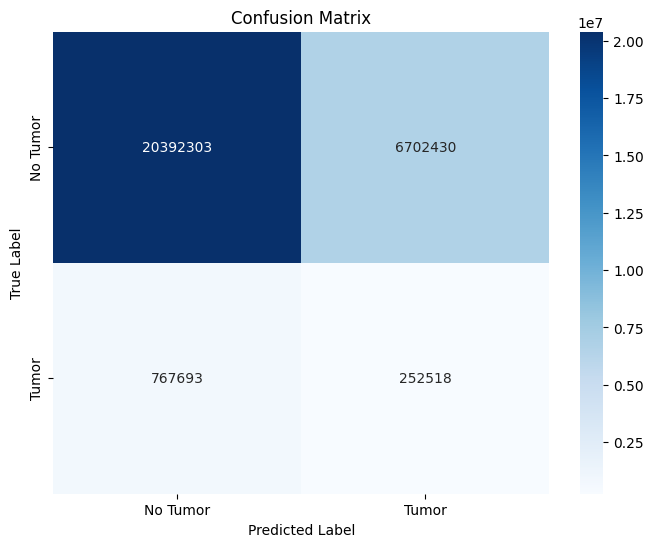

In [ ]:
def plot_confusion_matrix(conf_matrix, classes):
    """
    This function plots a given confusion matrix.
    
    Parameters:
    - conf_matrix: numpy array, the confusion matrix to be plotted
    - classes: list of class names for the axis labels
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def incremental_conf_matrix(model, loader, device, classes):
    model.to(device)
    model.eval()
    conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # Ensure binary predictions by thresholding and converting to integer
            predicted = (outputs > 0.5).float()
            preds = predicted.view(-1).cpu().numpy().astype(int)  # Ensure binary and convert to int
            actuals = masks.view(-1).cpu().numpy().astype(int)    # Ensure masks are also int

            # Incrementally update confusion matrix
            conf_matrix += confusion_matrix(actuals, preds, labels=range(len(classes)))
    return conf_matrix


model.to(device)

conf_matrix = incremental_conf_matrix(model, valid_loader, device, classes=[0, 1])
plot_confusion_matrix(conf_matrix, classes=['No Tumor', 'Tumor'])




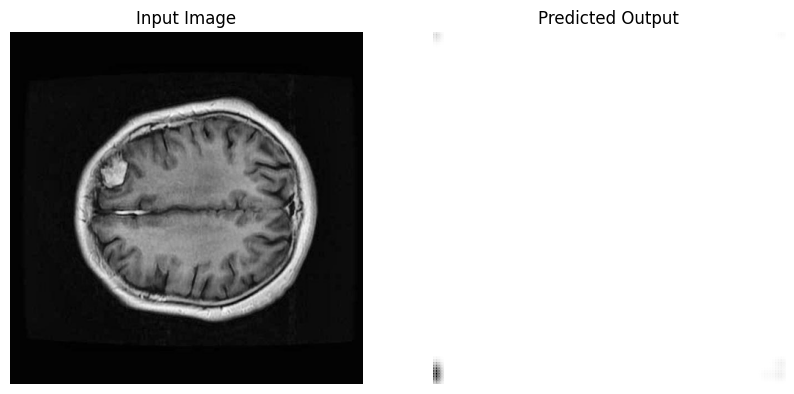

In [ ]:
# Save the trained model
torch.save(model.state_dict(), os.path.join(base_dir, 'cnn_encoderdecoder.pth'))

# Load the trained model
model.load_state_dict(torch.load(os.path.join(base_dir, 'cnn_encoderdecoder.pth')))
model.eval()

# Run inference on a sample image
image_path = os.path.join(base_dir, "semantic-segmentation/test2/images/27_jpg.rf.b2a2b9811786cc32a23c46c560f04d07.jpg")
image = Image.open(image_path).convert("L")
input_image = image_transform(image).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(input_image)
output_np = output.squeeze(0).cpu().numpy()

# Plot the input image and the segmentation mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_np[0], cmap='gray')
plt.title('Predicted Output')
plt.axis('off')
plt.show()

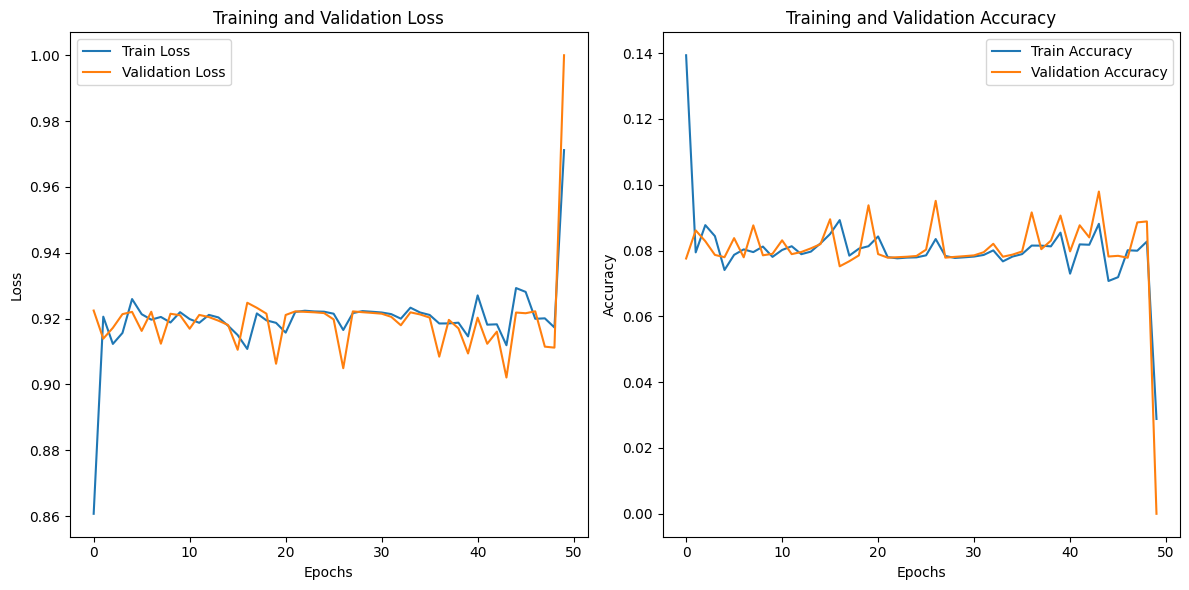

In [ ]:
from matplotlib import pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Load training and validation accuracy if calculated
# Assuming train_accuracy_history and valid_accuracy_history are returned and saved from your training function
# If they are not calculated and saved, you would need to implement that similarly to how loss is tracked
train_accuracy_history = [1 - loss for loss in train_loss_history]  # Example calculation, replace with actual if available
valid_accuracy_history = [1 - loss for loss in valid_loss_history]  # Example calculation, replace with actual if available

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(valid_accuracy_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()